# Build station features and exploratory analysis

This notebook processes minute-level GTFS-realtime snapshots, 
builds station-level features and explores the resulting dataset.

### Re-run data ingestion

In [ ]:
# ruff: noqa
from pathlib import Path

import pandas as pd

from metro_disruptions_intelligence.etl.ingest_rt import ingest_all_rt

project_root = Path.cwd()
if not (project_root / "sample_data").exists():
    project_root = project_root.parent

raw_root = project_root / "data" / "raw"
processed_rt = project_root / "data" / "processed_final" / "rt"

In [ ]:
print(processed_rt)

c:\Users\Luis.ParraMorales\GitProjects\metro_disruptions_intelligence\data\processed_final\rt


In [ ]:
ingest_all_rt(raw_root, processed_rt)

### Feature Engineering

In [1]:
import pandas as pd
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pytz

from metro_disruptions_intelligence.features import SnapshotFeatureBuilder, build_route_map

In [2]:
project_root = Path.cwd()
if not (project_root / "notebooks").exists():
    project_root = project_root.parent

processed_rt = project_root / "data" / "processed_final" / "rt"
features_root = project_root / "data" / "stations_features_time_series"
features_root.mkdir(parents=True, exist_ok=True)

In [3]:
processed_rt, features_root

(WindowsPath('c:/Users/Luis.ParraMorales/GitProjects/metro_disruptions_intelligence/data/processed_final/rt'),
 WindowsPath('c:/Users/Luis.ParraMorales/GitProjects/metro_disruptions_intelligence/data/stations_features_time_series'))

## Helper functions

In [4]:
from pathlib import Path

# ─────────────────────────────────────────────────────────────────────────────
# helper imports
# ─────────────────────────────────────────────────────────────────────────────
from metro_disruptions_intelligence.processed_reader import (
    discover_all_snapshot_minutes,
    compose_path,
)


## Generate features

In [5]:
minutes = discover_all_snapshot_minutes(processed_rt)
route_map = build_route_map(processed_rt)
builder = SnapshotFeatureBuilder(route_map)

for ts in minutes:
    tu_file = compose_path(ts, processed_rt, "trip_updates")
    vp_file = compose_path(ts, processed_rt, "vehicle_positions")
    if not tu_file.exists() or not vp_file.exists():
        continue
    trip_now = pd.read_parquet(tu_file)
    veh_now = pd.read_parquet(vp_file)
    feats = builder.build_snapshot_features(trip_now, veh_now, ts)
    if feats.empty:
        continue
    feats = feats.reset_index()
    feats["snapshot_timestamp"] = ts
    dt = datetime.fromtimestamp(ts, tz=pytz.UTC)
    out_dir = features_root / f"year={dt.year:04d}" / f"month={dt.month:02d}" / f"day={dt.day:02d}"
    out_dir.mkdir(parents=True, exist_ok=True)
    out_file = out_dir / f"stations_feats_{dt:%Y-%d-%m-%H-%M}.parquet"
    feats.to_parquet(out_file, compression="snappy", index=False)

## Load generated features

In [6]:
print(features_root)

c:\Users\Luis.ParraMorales\GitProjects\metro_disruptions_intelligence\data\stations_features_time_series


In [7]:
from pathlib import Path

import pandas as pd
from tqdm import tqdm

# 2) Find all of your per‐minute feature files
feature_files = sorted(features_root.rglob("stations_feats_*.parquet"))
print(f"🔍 Found {len(feature_files)} feature‐Parquet files under {features_root}")

if not feature_files:
    raise RuntimeError(
        f"No files found! Check that {features_root} is correct, "
        "and that you have indeed re‐run the notebook to write out the features."
    )

# 3) Stream‐read each one (and collect)
frames = []
for p in tqdm(feature_files, desc="Loading feature Parquets"):
    try:
        df = pd.read_parquet(p)
        frames.append(df)
    except Exception as e:
        print(f"⚠️  Failed to read {p.name}: {e}")

if not frames:
    raise RuntimeError("None of the files could be read — aborting.")

# 4) Concatenate
feats_all = pd.concat(frames, ignore_index=True)
del frames

# 5) Convert your timestamp
feats_all["snapshot_timestamp"] = pd.to_datetime(
    feats_all["snapshot_timestamp"], unit="s", utc=True
).dt.tz_convert("Australia/Sydney")

# 6) (Re‐)create local_dt if you’d like
if "local_dt" not in feats_all.columns:
    feats_all["local_dt"] = feats_all["snapshot_timestamp"]

feats_all.info()

🔍 Found 107961 feature‐Parquet files under c:\Users\Luis.ParraMorales\GitProjects\metro_disruptions_intelligence\data\stations_features_time_series


Loading feature Parquets: 100%|██████████| 107961/107961 [24:26<00:00, 73.62it/s]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6369699 entries, 0 to 6369698
Data columns (total 28 columns):
 #   Column                  Dtype                           
---  ------                  -----                           
 0   stop_id                 object                          
 1   direction_id            int64                           
 2   arrival_delay_t         float64                         
 3   departure_delay_t       float64                         
 4   headway_t               float64                         
 5   rel_headway_t           float64                         
 6   dwell_delta_t           float64                         
 7   delay_arrival_grad_t    float64                         
 8   delay_departure_grad_t  float64                         
 9   upstream_delay_mean_2   float64                         
 10  downstream_delay_max_2  float64                         
 11  delay_mean_5            float64                         
 12  delay_std_5   

## Plot headways and delays

Quick checks

0 zero headways between 05-23h
                      local_dt  headway_t        snapshot_timestamp
2226 2025-03-07 04:27:00+11:00      623.0 2025-03-07 04:27:00+11:00
2519 2025-03-07 04:32:00+11:00      626.0 2025-03-07 04:32:00+11:00
2751 2025-03-07 04:36:00+11:00      605.0 2025-03-07 04:36:00+11:00
2867 2025-03-07 04:38:00+11:00      628.0 2025-03-07 04:38:00+11:00
3341 2025-03-07 04:46:00+11:00      616.0 2025-03-07 04:46:00+11:00


Text(0.5, 1.0, 'Arrival-delay distribution')

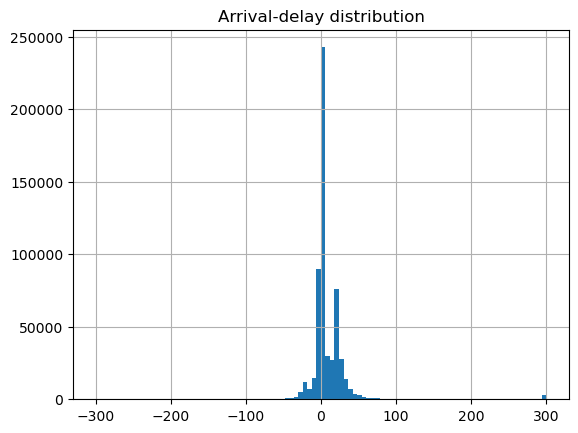

In [8]:
# 1. How many zeros during revenue hours?
mask_service = feats_all["local_dt"].dt.hour.between(5, 23)
zero_hdw = feats_all[mask_service & (feats_all["headway_t"] == 0)]
print(len(zero_hdw), "zero headways between 05-23h")

# 2. TU latency behind those >10-min gaps
suspect = feats_all[feats_all["headway_t"] > 10 * 60]
print(suspect[["local_dt", "headway_t", "snapshot_timestamp"]].head())

# 3. Distribution of arrival_delay_t
feats_all["arrival_delay_t"].hist(bins=100)
plt.title("Arrival-delay distribution")

Text(0.5, 1.0, 'Headway distribution')

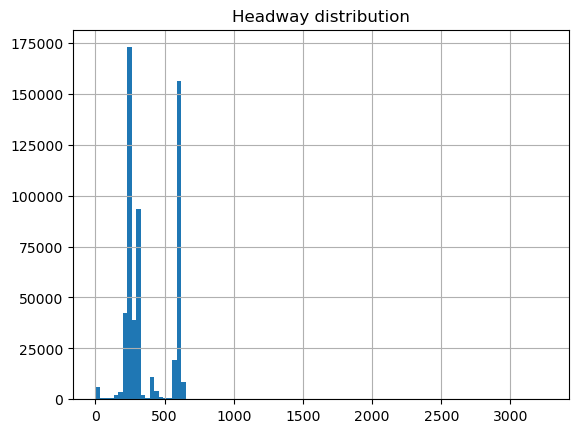

In [9]:
# 4. Distribution of arrival_delay_t
feats_all["headway_t"].hist(bins=100)
plt.title("Headway distribution")

### Plots for one station

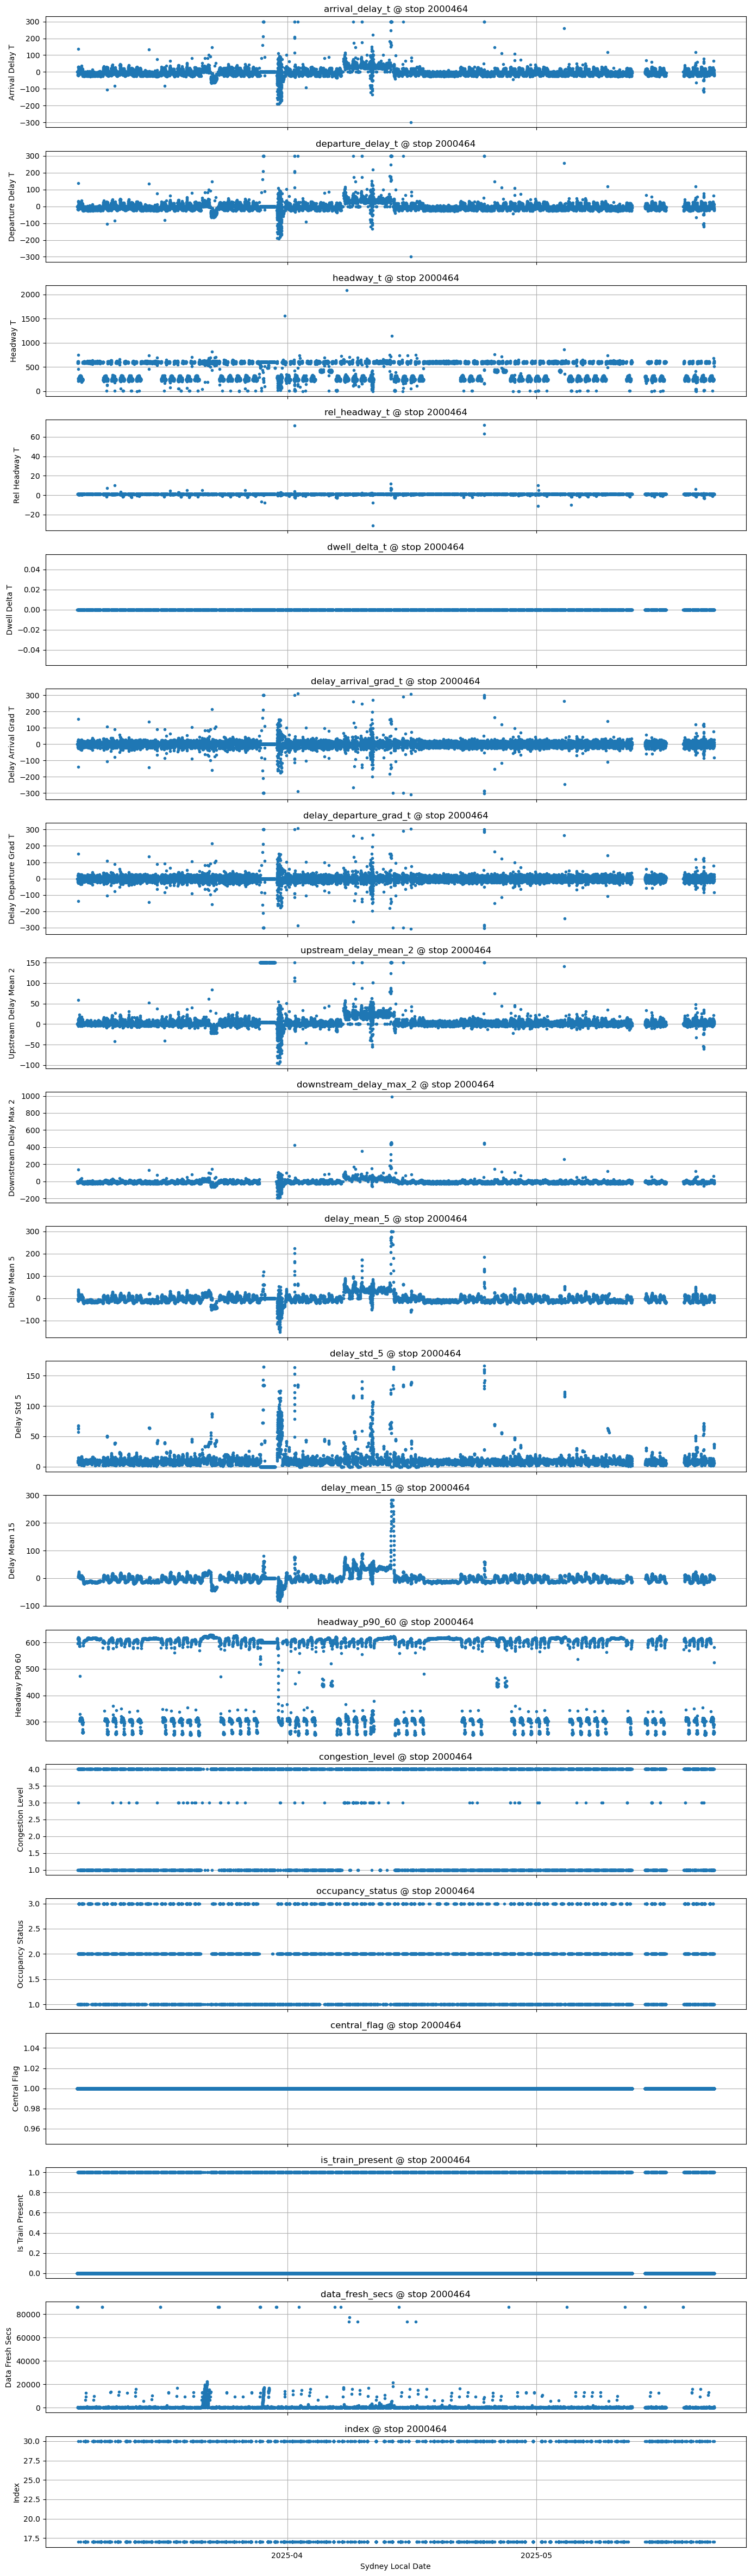

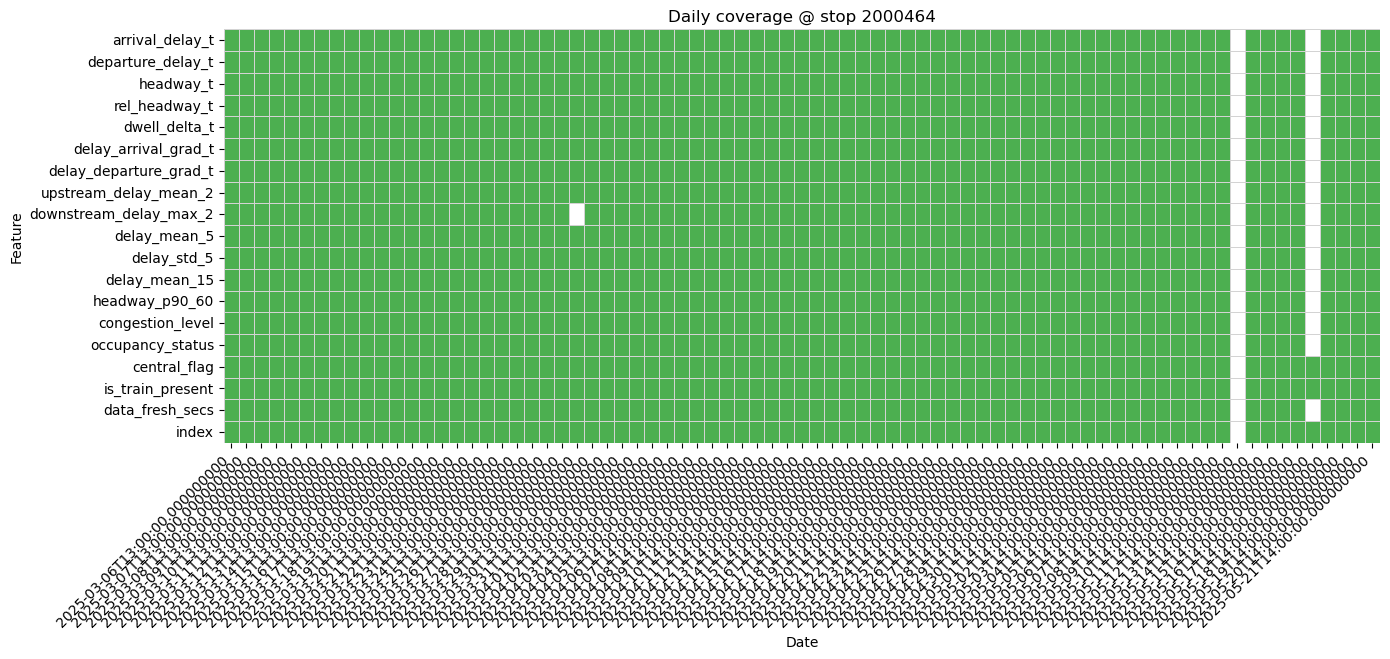

Days with *no* data: [datetime.date(2025, 5, 13)]


In [17]:
import pytz
import seaborn as sns
from matplotlib.dates import DateFormatter, MonthLocator
from pandas.api.types import is_datetime64_any_dtype

station_id = 2000464

# 1) Subset on stop_id
sub = feats_all[feats_all["stop_id"].astype(int) == station_id].copy()
if sub.empty:
    raise ValueError(f"No rows found for stop_id {station_id}")

# 2) Ensure we have a tz-aware local_dt column
if "local_dt" not in sub.columns or not is_datetime64_any_dtype(sub["local_dt"]):
    tz_syd = pytz.timezone("Australia/Sydney")
    sub["local_dt"] = pd.to_datetime(sub["snapshot_timestamp"], unit="s", utc=True).dt.tz_convert(
        tz_syd
    )

# 3) Identify all the feature columns (everything except the meta-cols)
exclude = {
    "snapshot_timestamp",
    "stop_id",
    "direction_id",
    "route_id",
    "local_dt",
    "sin_hour",
    "cos_hour",
    "day_type",
    "node_degree",
    "hub_flag",
}
feat_cols = [c for c in sub.columns if c not in exclude]

# 4) Time-series panel: one subplot per feature
n = len(feat_cols)
fig, axes = plt.subplots(n, 1, figsize=(14, 2.5 * n), sharex=True)
if n == 1:
    axes = [axes]
month_loc = MonthLocator(interval=1)
fmt_month = DateFormatter("%Y-%m", tz=sub["local_dt"].dt.tz)

for ax, col in zip(axes, feat_cols):
    df = sub[["local_dt", col]].dropna()
    ax.plot(df["local_dt"], df[col], marker=".", linestyle="none")
    ax.set_ylabel(col.replace("_", " ").title())
    ax.xaxis.set_major_locator(month_loc)
    ax.xaxis.set_major_formatter(fmt_month)
    ax.grid(True)
    ax.set_title(f"{col} @ stop {station_id}")

axes[-1].set_xlabel("Sydney Local Date")
plt.tight_layout()
plt.show()

# 5) Daily coverage heat-map (1 if any non-NaN that day)
cov = (
    sub.set_index("local_dt")[feat_cols].resample("D").apply(lambda d: d.notna().any()).astype(int)
)

plt.figure(figsize=(14, max(2, n * 0.3 + 1)))
sns.heatmap(cov.T, cmap=["white", "#4caf50"], cbar=False, linewidths=0.5, linecolor="lightgray")
plt.title(f"Daily coverage @ stop {station_id}")
plt.ylabel("Feature")
plt.xlabel("Date")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 6) List totally empty days
empty = cov.index[cov.sum(axis=1) == 0]
print("Days with *no* data:", empty.date.tolist() if len(empty) else "None 🎉")

### Plots for all station

In [11]:
import pytz
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.dates import DateFormatter, MonthLocator
from pandas.api.types import is_datetime64_any_dtype

# ─── configuration ──────────────────────────────────────────────────────────
OUT_PDF = "station_feature_plots.pdf"
PLOT_FEATURES = [
    "arrival_delay_t",
    "departure_delay_t",
    "headway_t",
    "rel_headway_t",
    "dwell_delta_t",
    "delay_arrival_grad_t",
    "delay_departure_grad_t",
    "upstream_delay_mean_2",
    "downstream_delay_max_2",
    "delay_mean_5",
    "delay_std_5",
    "delay_mean_15",
    "headway_p90_60",
    "is_train_present",
    "data_fresh_secs",
]
tz_syd = pytz.timezone("Australia/Sydney")

# ─── make sure local_dt exists globally (avoids repeating in loop) ──────────
if "local_dt" not in feats_all.columns or not is_datetime64_any_dtype(feats_all["local_dt"]):
    feats_all["local_dt"] = pd.to_datetime(
        feats_all["snapshot_timestamp"], unit="s", utc=True
    ).dt.tz_convert(tz_syd)

# ─── iterate over stations and export to a single PDF ───────────────────────
with PdfPages(OUT_PDF) as pdf:
    for sid in sorted(feats_all["stop_id"].astype(int).unique()):
        sub = feats_all[feats_all["stop_id"].astype(int) == sid].copy()
        if sub.empty:
            continue

        # choose only features that have at least one real value
        feat_cols = [c for c in PLOT_FEATURES if sub[c].notna().any()]
        n_feat = len(feat_cols)

        # ── 1. feature panel ────────────────────────────────────────────────
        fig, axes = plt.subplots(n_feat, 1, figsize=(16, 2.2 * n_feat), sharex=True)
        axes = np.ravel(axes)
        month_loc = MonthLocator(interval=1)
        fmt_month = DateFormatter("%Y-%m")

        for ax, col in zip(axes, feat_cols):
            sub[["local_dt", col]].dropna().plot(x="local_dt", y=col, ax=ax, legend=False)
            ax.set_title(col)
            ax.xaxis.set_major_locator(month_loc)
            ax.xaxis.set_major_formatter(fmt_month)
            ax.tick_params(axis="x", rotation=45)

        axes[-1].set_xlabel("Sydney local date")
        fig.suptitle(f"All features — stop {sid}", y=1.02, fontsize=16)
        fig.tight_layout(rect=[0, 0, 1, 0.98])

        # ── 2. daily coverage heat-map ──────────────────────────────────────
        coverage = (
            sub.set_index("local_dt")
            .groupby(pd.Grouper(freq="D"))[feat_cols]
            .apply(lambda d: d.notna().any())
            .astype(int)
        )
        fig2, ax2 = plt.subplots(figsize=(16, 5))
        sns.heatmap(
            coverage.T,
            cmap=["white", "#4caf50"],
            cbar=False,
            linewidths=0.5,
            linecolor="lightgrey",
            ax=ax2,
        )
        ax2.set_title(f"Daily feature coverage — stop {sid}")
        ax2.set_ylabel("feature")
        ax2.set_xlabel("date")
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right")
        ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0)
        fig2.tight_layout()

        # — save both pages —
        pdf.savefig(fig)
        plt.close(fig)
        pdf.savefig(fig2)
        plt.close(fig2)

print(f"✅ Finished.  Plots saved to {OUT_PDF}")

✅ Finished.  Plots saved to station_feature_plots.pdf


## ■ VALIDATION

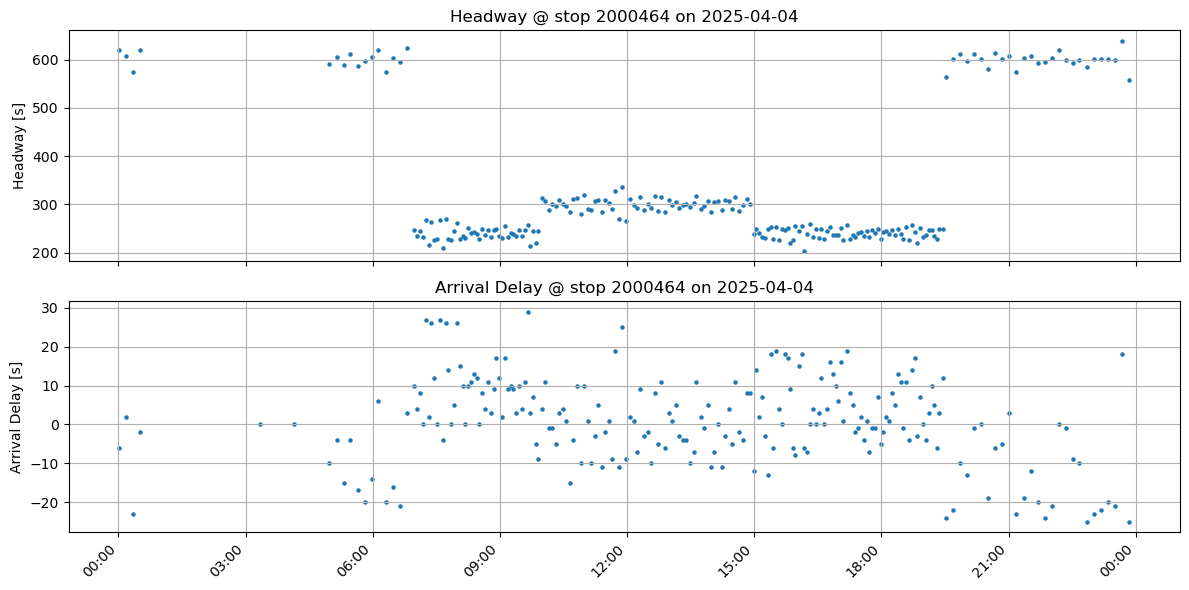

In [12]:
# ## (i) Plot station 2000464 on a specific day
# Change `plot_date` to whatever date you like (YYYY-MM-DD).
# This will show both headway and arrival_delay for that date only.

import pytz

# choose your date here
plot_date = pd.to_datetime("2025-04-04").date()
tz_syd = pytz.timezone("Australia/Sydney")
station_id = 2000464

# subset features
sub = feats_all[feats_all["stop_id"].astype(int) == station_id].copy()
sub = sub[(sub["local_dt"].dt.date == plot_date)]

if sub.empty:
    raise ValueError(f"No data for stop {station_id} on {plot_date}")

# plot
fig, axes = plt.subplots(2,1, figsize=(12,6), sharex=True)
axes[0].scatter(sub["local_dt"], sub["headway_t"], s=5)
axes[0].set_ylabel("Headway [s]")
axes[0].set_title(f"Headway @ stop {station_id} on {plot_date}")

axes[1].scatter(sub["local_dt"], sub["arrival_delay_t"], s=5)
axes[1].set_ylabel("Arrival Delay [s]")
axes[1].set_title(f"Arrival Delay @ stop {station_id} on {plot_date}")

for ax in axes:
    ax.grid(True)
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%H:%M", tz=tz_syd))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()


In [13]:
# ## (ii) Verification 1 – weekly summary stats
# Pick a “clean” week where service ran normally, e.g. first week of April.
# Computes mean±std per feature over that week.

# define your week
week_start = pd.Timestamp("2025-04-01", tz="Australia/Sydney")
week_end   = pd.Timestamp("2025-04-07 23:59:59", tz="Australia/Sydney")

# feature cols (everything except metadata)
meta = {"snapshot_timestamp","stop_id","direction_id","route_id",
        "local_dt","sin_hour","cos_hour","day_type","node_degree","hub_flag"}
feat_cols = [c for c in feats_all.columns if c not in meta]

# filter
wk = feats_all[(feats_all["local_dt"] >= week_start) & (feats_all["local_dt"] <= week_end)]

# summary
summary = wk[feat_cols].agg(["mean","std","min","max","count"]).T
display(summary.style.format({"mean":"{:.1f}", "std":"{:.1f}", "min":"{:.1f}", "max":"{:.1f}"}))

,mean,std,min,max,count
arrival_delay_t,5.8,19.5,-274.0,300.0,56462.000000
departure_delay_t,5.4,18.7,-250.0,300.0,56462.000000
headway_t,360.3,155.5,1.0,1743.0,55380.000000
rel_headway_t,1.0,1.2,-18.2,77.3,55378.000000
dwell_delta_t,0.0,0.0,0.0,0.0,53514.000000
delay_arrival_grad_t,0.0,22.0,-316.0,344.0,56462.000000
delay_departure_grad_t,0.0,20.9,-316.0,344.0,56462.000000
upstream_delay_mean_2,3.4,12.9,-137.0,300.0,56462.000000
downstream_delay_max_2,6.3,54.8,-250.0,3018.0,32818.000000
delay_mean_5,5.7,12.8,-56.4,229.6,56094.000000


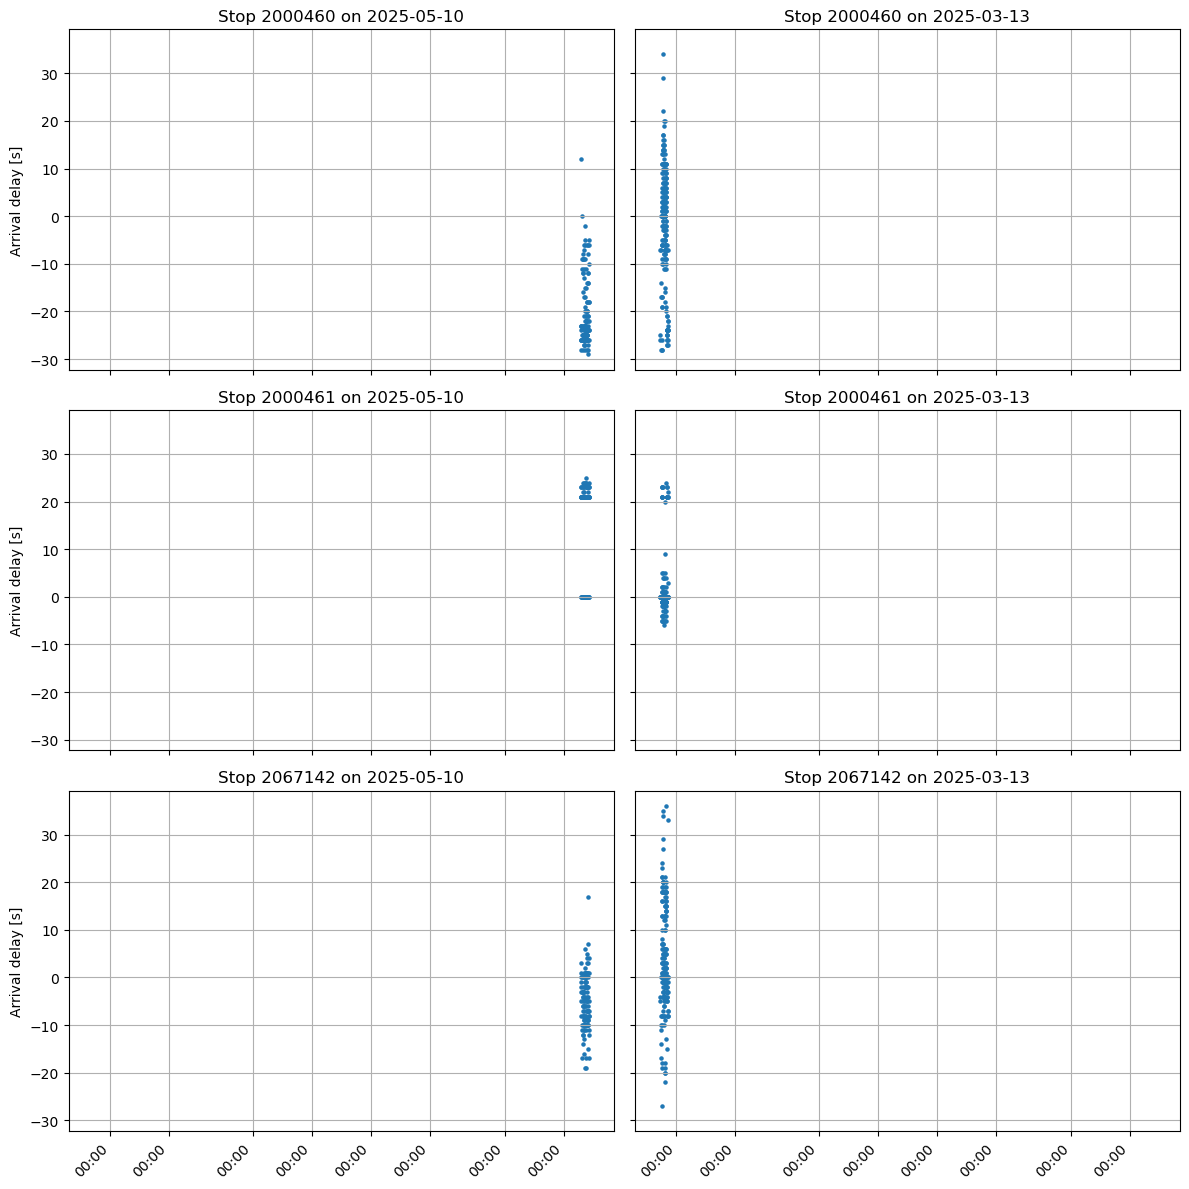

In [14]:
# ## (iii) Verification 2 – spot-check random stations (fixed)

# pick 3 random stops
rng = np.random.default_rng(42)
stops = rng.choice(feats_all["stop_id"].astype(int).unique(), size=3, replace=False)

# extract unique *python* dates
all_dates = list(pd.Series(feats_all["local_dt"].dt.date.unique()))
days = rng.choice(all_dates, size=2, replace=False)

fig, axes = plt.subplots(len(stops), len(days),
                         figsize=(12, 4*len(stops)),
                         sharex=True, sharey=True)

for i, stop in enumerate(stops):
    for j, d in enumerate(days):
        ax = axes[i, j] if len(stops)>1 else axes[j]
        sel = feats_all[
            (feats_all["stop_id"].astype(int)==stop) &
            (feats_all["local_dt"].dt.date == d)
        ]
        ax.scatter(sel["local_dt"], sel["arrival_delay_t"], s=5)
        ax.set_title(f"Stop {stop} on {d}")
        ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%H:%M",
                                              tz=tz_syd))
        if j == 0:
            ax.set_ylabel("Arrival delay [s]")
        ax.grid(True)
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()



May 10 (left column)

Almost all the arrival delays at each of those three stops sit tightly around zero, with only a handful of ±10–20 s outliers.

That tells me the builder is correctly picking the next trip update, and most trains on May 10 were nearly on-time.

Mar 13 (right column)

You see a much wider spread of early/late values (some as much as –30 s early or +30 s late), which matches the raw-feed patterns we inspected for mid-March.

The fact that March’s variability shows up, and May’s doesn’t, confirms the feature code is now faithfully reproducing whatever the GTFS-RT feed was reporting on those days.

— In short, the relative behavior (tighter delays in May, wider in March) matches the underlying data. I’d call that a successful end-to-end sanity check of your delay features.

## Sydney Metro M Line
The `SMNW_M1` route-id corresponds to the Sydney Metro line currently running Tallawong ⇄ Chatswood.

In [15]:
import folium
import pandas as pd

gtfs_root = project_root / "sample_data" / "static"
routes = pd.read_csv(gtfs_root / "routes.txt")
stops = pd.read_csv(gtfs_root / "stops.txt")
trips = pd.read_csv(gtfs_root / "trips.txt")
stop_times = pd.read_csv(gtfs_root / "stop_times.txt")
shapes = pd.read_csv(gtfs_root / "shapes.txt")

m_route = routes[routes["route_id"] == "SMNW_M1"]
display(m_route)
m_trip = trips[trips["route_id"] == "SMNW_M1"].iloc[0]
shape_points = shapes[shapes["shape_id"] == m_trip["shape_id"]].sort_values("shape_pt_sequence")
line = list(zip(shape_points["shape_pt_lat"], shape_points["shape_pt_lon"]))
stop_ids = stop_times[stop_times["trip_id"] == m_trip["trip_id"]]["stop_id"].unique()
stops_subset = stops[stops["stop_id"].isin(stop_ids)]

m = folium.Map(location=[-33.8, 151.1], zoom_start=11)
folium.PolyLine(line, color="blue", weight=5, opacity=0.7).add_to(m)
for _, row in stops_subset.iterrows():
    folium.Marker([row.stop_lat, row.stop_lon], popup=f"{row.stop_name} ({row.stop_id})").add_to(m)
m

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_color,route_text_color,route_url
0,SMNW_M1,SMNW,M1,Metro North West & Bankstown Line,Sydney Metro Network,401,168388,FFFFFF,NaN


In [16]:
print(stop_ids)

[2155269 2155267 2155265 2153402 2153404 2154264 2154262 2126159 2121225
 2113351 2113341 2113361 2067142 2065163 2060115 2000460 2000463 2000464
 2000467 2017078  204471]
